In [1]:
from torchfsm.operator import Laplacian,Operator,VorticityConvection
from torchfsm.mesh import MeshGrid
from torchfsm.fields import diffused_noise,kolm_force
from tqdm.auto import tqdm
import torch,random
import numpy as np
import matplotlib.pyplot as plt
import yaml

def KolmVorticity(force:Operator,Re=1000)->Operator:
    return -VorticityConvection() + 1/Re*Laplacian()+force

mesh=MeshGrid([(0,2*np.pi,128),(0,2*np.pi,128)],device="cuda")
x,y=mesh.bc_mesh_grid()
kolm=KolmVorticity(kolm_force(y),Re=100)

/home/liu/anaconda3/envs/deeplearning/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Train
shape: [50, 51, 1, 128, 128] > [500, 6, 1, 128, 128]

In [2]:
trajs=[]
for i in tqdm(range(10)):
    start=random.randint(1500,1990)
    def traj_control_func(t):
        if t>start and t<start+7:
            return True
        return False
    u0=diffused_noise(mesh,n_batch=50)
    traj=kolm.integrate(
        u_0=u0,
        mesh=mesh,
        dt=0.5/50,
        step=40*50,
        trajectory=True,
        trajectory_control_func=traj_control_func,
        include_start=False
    )
    trajs.append(traj.cpu().numpy())
trajs=np.concatenate(trajs,axis=0)
print(trajs.shape)
print(np.max(trajs))
print(np.min(trajs))
print(np.isnan(trajs).any())
np.save("kolmogorov_train.npy",trajs)

  0%|          | 0/10 [00:00<?, ?it/s]

(500, 6, 1, 128, 128)
14.877626
-14.550373
False


## Test

[30, 201, 1, 160, 160]

In [3]:
start=random.randint(1500,1790)
def traj_control_func(t):
    if t>start and t<start+202:
        return True
    return False
u0=diffused_noise(mesh,n_batch=30)
traj=kolm.integrate(
    u_0=u0,
    mesh=mesh,
    dt=0.5/50,
    step=40*50,
    trajectory=True,
    trajectory_control_func=traj_control_func,
    include_start=False
)
traj=traj.cpu().numpy()
print(traj.shape)
print(np.max(traj))
print(np.min(traj))
print(np.isnan(traj).any())
np.save("kolmogorov_test.npy",traj)

(30, 201, 1, 128, 128)
14.278666
-14.371614
False


In [17]:
yaml.dump(
    {
        "train": "kolmogorov_train.npy",
        "test": "kolmogorov_test.npy",
        "mesh": [list(i) for i in mesh.mesh_info],
        "dt": 0.5/50,
        "step": [40*50,40*50],
        "vrange":[-15,15],
        "Re":100
    },
    open("kolmogorov.yaml","w")
)

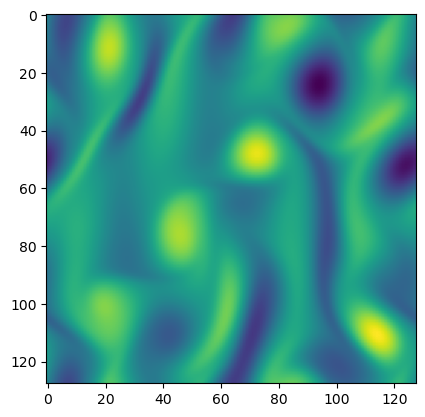

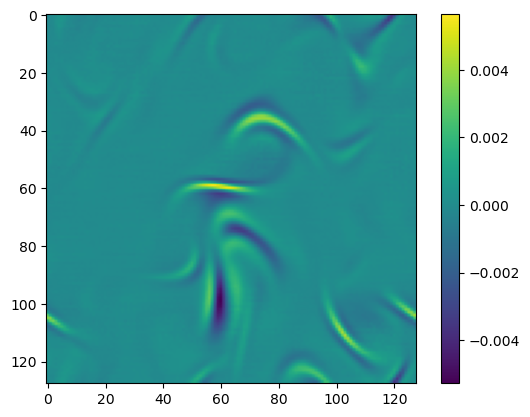

In [21]:
kolm=KolmVorticity(kolm_force(y),Re=100)
mesh=MeshGrid([(0,2*np.pi,128),(0,2*np.pi,128)],device="cuda")
kolm.register_mesh(mesh,n_channel=1)

def constrain_func(u_0,u_1):
    dudt=(u_1-u_0)/(0.5/50)
    u_mid=0.5*(u_0+u_1)
    return (dudt-kolm(u_mid))

npf=np.load("./kolmogorov_train.npy")
u0=torch.from_numpy(npf[0:1,2,...]).float().to("cuda")
u_1=torch.from_numpy(npf[0:1,3,...]).float().to("cuda")
plt.imshow(u0[0,0,...].cpu().numpy())
plt.show()
residual=constrain_func(u0,u_1)
plt.imshow(residual[0,0,...].cpu().numpy())
plt.colorbar()
plt.show()

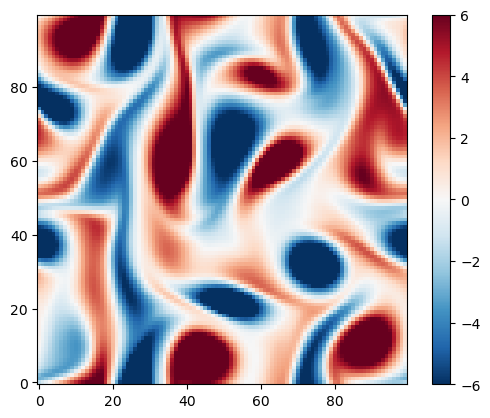

In [28]:
plt.imshow(traj[0,40,0], vmin=-6.0,vmax=6.0, cmap="RdBu_r", origin="lower")
plt.colorbar()